## Setup

In [ ]:
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import lru_cache
from dataclasses import dataclass
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Display / plotting defaults (simple + readable)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

RNG_SEED = 42
np.random.seed(RNG_SEED)


In [ ]:
def find_project_root(start: Path | None = None) -> Path:
    """
    Find the folder that contains gt.tsv + writers.tsv + (enrollment/, verification/).
    Works whether it runs from the notebook folder or one level above.
    """
    start = Path.cwd() if start is None else start
    candidates = [start] + list(start.parents)

    for p in candidates:
        if (p / "gt.tsv").exists() and (p / "writers.tsv").exists():
            return p
        if (p / "SignatureVerification" / "gt.tsv").exists() and (p / "SignatureVerification" / "writers.tsv").exists():
            return p / "SignatureVerification"

    raise FileNotFoundError(
        "Could not locate project root. Expected gt.tsv and writers.tsv "
        "either in the current folder or in ./SignatureVerification/."
    )

ROOT = find_project_root()
ENROLL_DIR = ROOT / "enrollment"
VERIF_DIR  = ROOT / "verification"
GT_PATH    = ROOT / "gt.tsv"
WRITERS_PATH = ROOT / "writers.tsv"

print("ROOT      =", ROOT)
print("ENROLL    =", ENROLL_DIR)
print("VERIF     =", VERIF_DIR)
print("GT        =", GT_PATH)
print("WRITERS   =", WRITERS_PATH)

assert ENROLL_DIR.exists(), "Missing enrollment/ directory."
assert VERIF_DIR.exists(),  "Missing verification/ directory."
assert GT_PATH.exists(),     "Missing gt.tsv."
assert WRITERS_PATH.exists(),"Missing writers.tsv."


ROOT      = c:\Users\aqual\Desktop\M\Pattern Recognition\Project\Ex4 Signature Verification\SignatureVerification
ENROLL    = c:\Users\aqual\Desktop\M\Pattern Recognition\Project\Ex4 Signature Verification\SignatureVerification\enrollment
VERIF     = c:\Users\aqual\Desktop\M\Pattern Recognition\Project\Ex4 Signature Verification\SignatureVerification\verification
GT        = c:\Users\aqual\Desktop\M\Pattern Recognition\Project\Ex4 Signature Verification\SignatureVerification\gt.tsv
WRITERS   = c:\Users\aqual\Desktop\M\Pattern Recognition\Project\Ex4 Signature Verification\SignatureVerification\writers.tsv


## 1. Data loading + metadata table (single source of truth)

In [ ]:
SIG_COLUMNS = ["t", "x", "y", "pressure", "penup", "azimuth", "inclination"]

def load_signature_tsv(path: Path) -> pd.DataFrame:
    """
    Loads one signature TSV (no header). Returns a cleaned DataFrame with standard columns.
    Assumes 7 columns: t, x, y, pressure, penup, azimuth, inclination.
    """
    df = pd.read_csv(path, sep="\t", header=None)

    if df.shape[1] != 7:
        raise ValueError(f"{path.name}: expected 7 columns, got {df.shape[1]}.")

    df.columns = SIG_COLUMNS

    # Ensure numeric (coerce errors to NaN then drop)
    for c in SIG_COLUMNS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna().reset_index(drop=True)

    # Sort by time just in case
    df = df.sort_values("t").reset_index(drop=True)

    return df


In [ ]:
def load_writers(path: Path) -> pd.DataFrame:
    """
    Loads writers.tsv. Many versions are just a single column listing writer IDs.
    Returns a DataFrame with at least: writer_id (str, zero-padded to 3).
    """
    df = pd.read_csv(path, sep="\t", header=None)

    if df.shape[1] == 1:
        df = df.rename(columns={0: "writer_id"})
    else:
        # If there are multiple columns, keep the first as writer_id by default.
        df = df.rename(columns={df.columns[0]: "writer_id"})

    df["writer_id"] = df["writer_id"].astype(str).str.zfill(3)
    df = df.drop_duplicates(subset=["writer_id"]).sort_values("writer_id").reset_index(drop=True)
    return df


def load_gt(path: Path) -> pd.DataFrame:
    gt = pd.read_csv(path, sep="\t", header=None, dtype=str).dropna(how="all")

    if gt.shape[1] == 3:
        gt = gt.rename(columns={0: "writer_id", 1: "verif_id", 2: "label"})
        gt["writer_id"] = gt["writer_id"].astype(str).str.extract(r"(\d{3})")[0]
        gt["verif_id"]  = gt["verif_id"].astype(str).str.extract(r"(\d{2})")[0]
    elif gt.shape[1] == 2:
        gt = gt.rename(columns={0: "key", 1: "label"})
        m = gt["key"].astype(str).str.extract(r"(?P<writer_id>\d{3})-(?P<verif_id>\d{2})")
        if m.isna().any(axis=1).any():
            bad = gt[m.isna().any(axis=1)]["key"].head(5).tolist()
            raise ValueError(f"Could not parse some GT keys into writer_id/verif_id. Examples: {bad}")
        gt = pd.concat([m, gt[["label"]]], axis=1)
    else:
        raise ValueError(f"Unexpected gt.tsv format: {gt.shape[1]} columns.")

    # Normalize ids 
    gt["writer_id"] = gt["writer_id"].astype(str).str.zfill(3)
    gt["verif_id"]  = gt["verif_id"].astype(str).str.zfill(2)

    # Robust label parsing 
    raw = gt["label"].astype(str).str.strip().str.lower()

    # common textual labels (just in case)
    label_map = {
        "1": 1, "0": 0,
        "g": 1, "genuine": 1, "gen": 1, "true": 1,
        "f": 0, "forgery": 0, "forged": 0, "fake": 0, "false": 0,
    }
    gt["label_num"] = raw.map(label_map)

    # fallback: numeric coercion (handles " 1 " etc.)
    gt["label_num"] = gt["label_num"].where(gt["label_num"].notna(),
                                           pd.to_numeric(raw, errors="coerce"))

    # drops rows where label still missing (header lines, blanks, etc.)
    bad_rows = gt["label_num"].isna().sum()
    if bad_rows > 0:
        print(f"[load_gt] Dropping {bad_rows} GT rows with unparsable labels.")

    gt = gt.dropna(subset=["label_num"]).copy()
    gt["label"] = gt["label_num"].astype(int)
    gt = gt.drop(columns=["label_num"])

    return gt


writers_df = load_writers(WRITERS_PATH)
gt_df = load_gt(GT_PATH)

display(writers_df.head())
display(gt_df.head())
print("Writers:", len(writers_df), "| GT rows:", len(gt_df))


,writer_id
0,001
1,002
2,003
3,004
4,005


,writer_id,verif_id,label
0,001,01,1
1,001,02,1
2,001,03,0
3,001,04,0
4,001,05,1


Writers: 30 | GT rows: 1350


In [6]:
def parse_enroll_filename(name: str) -> dict:
    # e.g. "001-g-03.tsv" -> writer_id=001, kind="enroll", enroll_idx=03
    m = re.match(r"^(?P<w>\d{3})-g-(?P<i>\d{2})\.tsv$", name)
    if not m:
        return {}
    return {"writer_id": m.group("w"), "enroll_id": m.group("i")}


def parse_verif_filename(name: str) -> dict:
    # e.g. "001-04.tsv" -> writer_id=001, verif_id=04
    m = re.match(r"^(?P<w>\d{3})-(?P<i>\d{2})\.tsv$", name)
    if not m:
        return {}
    return {"writer_id": m.group("w"), "verif_id": m.group("i")}


def build_metadata_index(enroll_dir: Path, verif_dir: Path, gt: pd.DataFrame) -> pd.DataFrame:
    rows = []

    # Enrollment files
    for p in sorted(enroll_dir.glob("*.tsv")):
        info = parse_enroll_filename(p.name)
        if not info:
            continue
        rows.append({
            "split": "enrollment",
            "writer_id": info["writer_id"],
            "sig_id": info["enroll_id"],
            "path": p,
            "label": np.nan,      # no label needed for enrollment
            "is_genuine": True,   # by definition in enrollment
        })

    # Verification files
    for p in sorted(verif_dir.glob("*.tsv")):
        info = parse_verif_filename(p.name)
        if not info:
            continue

        # Merge GT label if available
        match = gt[(gt["writer_id"] == info["writer_id"]) & (gt["verif_id"] == info["verif_id"])]
        label = match["label"].iloc[0] if len(match) == 1 else np.nan

        rows.append({
            "split": "verification",
            "writer_id": info["writer_id"],
            "sig_id": info["verif_id"],
            "path": p,
            "label": label,
            # If your GT uses 1=genuine, 0=forgery, this is correct.
            # If it's reversed, we'll flip later once we confirm from the PDF / GT stats.
            "is_genuine": (label == 1) if pd.notna(label) else np.nan,
        })

    idx = pd.DataFrame(rows)

    # Sanity checks
    idx["writer_id"] = idx["writer_id"].astype(str).str.zfill(3)
    idx = idx.sort_values(["writer_id", "split", "sig_id"]).reset_index(drop=True)

    return idx


index_df = build_metadata_index(ENROLL_DIR, VERIF_DIR, gt_df)

display(index_df.head(10))
print(index_df["split"].value_counts(dropna=False))
print("Verification label NaNs:", index_df.loc[index_df["split"]=="verification", "label"].isna().sum())


,split,writer_id,sig_id,path,label,is_genuine
0,enrollment,001,01,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,NaN,True
1,enrollment,001,02,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,NaN,True
2,enrollment,001,03,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,NaN,True
3,enrollment,001,04,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,NaN,True
4,enrollment,001,05,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,NaN,True
5,verification,001,01,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,1.0,True
6,verification,001,02,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,1.0,True
7,verification,001,03,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,0.0,False
8,verification,001,04,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,0.0,False
9,verification,001,05,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,1.0,True


split
verification    1350
enrollment       150
Name: count, dtype: int64
Verification label NaNs: 0


In [7]:
# Expect: per writer -> 5 enrollment, 45 verification
counts = (index_df
          .groupby(["writer_id", "split"])
          .size()
          .unstack(fill_value=0)
         )

display(counts.head())

# Flag writers with unexpected counts
bad = counts[(counts.get("enrollment", 0) != 5) | (counts.get("verification", 0) != 45)]
print("Writers with unexpected file counts:", len(bad))
display(bad.head(20))


split,enrollment,verification
writer_id,,
001,5,45
002,5,45
003,5,45
004,5,45
005,5,45


Writers with unexpected file counts: 0


split,enrollment,verification
writer_id,,


In [11]:
index_df["y"] = pd.Series(pd.NA, index=index_df.index, dtype="Int64")
mask_v = index_df["split"].eq("verification")
index_df.loc[mask_v, "y"] = index_df.loc[mask_v, "label"].astype("Int64")

assert set(index_df.loc[mask_v, "y"].dropna().unique()) <= {0, 1}

print(index_df.loc[mask_v, "y"].value_counts())
print(index_df["y"].dtype)


y
0    750
1    600
Name: count, dtype: Int64
Int64


## 2. EDA helpers (load + quick stats + plots)

In [ ]:
@dataclass
class SigStats:
    n: int
    duration: float
    path_len: float
    mean_pressure: float
    strokes: int

def compute_stats(df: pd.DataFrame) -> SigStats:
    t = df["t"].to_numpy()
    x = df["x"].to_numpy()
    y = df["y"].to_numpy()
    p = df["pressure"].to_numpy()

    n = len(df)
    duration = float(t[-1] - t[0]) if n > 1 else 0.0

    dx = np.diff(x)
    dy = np.diff(y)
    path_len = float(np.sum(np.sqrt(dx*dx + dy*dy))) if n > 1 else 0.0

    mean_pressure = float(np.mean(p)) if n > 0 else 0.0

    # strokes: count pen-down segments using pressure > 0 (robust even if penup column is noisy)
    pen_down = (p > 0).astype(int)
    strokes = int(np.sum((pen_down[1:] == 1) & (pen_down[:-1] == 0))) + (1 if (n > 0 and pen_down[0] == 1) else 0)

    return SigStats(n=n, duration=duration, path_len=path_len, mean_pressure=mean_pressure, strokes=strokes)


def get_sig_row(writer_id: str, split: str, sig_id: str) -> pd.Series:
    writer_id = str(writer_id).zfill(3)
    sig_id = str(sig_id).zfill(2)
    row = index_df[(index_df["writer_id"] == writer_id) & (index_df["split"] == split) & (index_df["sig_id"] == sig_id)]
    if row.empty:
        raise KeyError(f"Not found: writer={writer_id}, split={split}, sig_id={sig_id}")
    return row.iloc[0]


def load_sig_from_row(row: pd.Series) -> pd.DataFrame:
    return load_signature_tsv(Path(row["path"]))


def plot_xy(df: pd.DataFrame, ax=None, color_by: str = "t", title: str | None = None):
    """
    XY trajectory. color_by in {"t", "pressure", None}
    """
    if ax is None:
        fig, ax = plt.subplots()

    x = df["x"].to_numpy()
    y = df["y"].to_numpy()

    # draws the path
    ax.plot(x, y, linewidth=1)

    if color_by in ("t", "pressure"):
        c = df[color_by].to_numpy()
        sc = ax.scatter(x, y, c=c, s=6)
        plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label=color_by)

    ax.set_aspect("equal", adjustable="datalim")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if title:
        ax.set_title(title)
    return ax


def plot_timeseries(df: pd.DataFrame, ax=None, title: str | None = None):
    """
    Plot x(t), y(t), pressure(t) + highlight pen-down regions (pressure>0).
    """
    if ax is None:
        fig, ax = plt.subplots()

    t = df["t"].to_numpy()
    ax.plot(t, df["x"].to_numpy(), label="x")
    ax.plot(t, df["y"].to_numpy(), label="y")
    ax.plot(t, df["pressure"].to_numpy(), label="pressure")

    # shade pen-down spans (pressure > 0)
    pen = (df["pressure"].to_numpy() > 0).astype(int)
    # finds contiguous pen-down segments
    starts = np.where((pen[1:] == 1) & (pen[:-1] == 0))[0] + 1
    ends   = np.where((pen[1:] == 0) & (pen[:-1] == 1))[0] + 1
    if len(pen) > 0 and pen[0] == 1:
        starts = np.r_[0, starts]
    if len(pen) > 0 and pen[-1] == 1:
        ends = np.r_[ends, len(pen)-1]

    for s, e in zip(starts, ends):
        ax.axvspan(t[s], t[e], alpha=0.08)

    ax.set_xlabel("t")
    ax.legend(loc="upper right")
    if title:
        ax.set_title(title)
    return ax


### Pick a writer + inspect enrollment variability

In [ ]:
WRITER = "001"  # change to any "001".."030"

enroll_rows = index_df[(index_df["writer_id"] == WRITER) & (index_df["split"] == "enrollment")].copy()
verif_rows  = index_df[(index_df["writer_id"] == WRITER) & (index_df["split"] == "verification")].copy()

print("Enrollment files:", len(enroll_rows))
print("Verification files:", len(verif_rows))
display(enroll_rows[["writer_id", "split", "sig_id", "path"]].head())
display(verif_rows[["writer_id", "split", "sig_id", "y", "path"]].head())


Enrollment files: 5
Verification files: 45


,writer_id,split,sig_id,path
0,001,enrollment,01,c:\Users\aqual\Desktop\M\Pattern Recognition\P...
1,001,enrollment,02,c:\Users\aqual\Desktop\M\Pattern Recognition\P...
2,001,enrollment,03,c:\Users\aqual\Desktop\M\Pattern Recognition\P...
3,001,enrollment,04,c:\Users\aqual\Desktop\M\Pattern Recognition\P...
4,001,enrollment,05,c:\Users\aqual\Desktop\M\Pattern Recognition\P...


,writer_id,split,sig_id,y,path
5,001,verification,01,1,c:\Users\aqual\Desktop\M\Pattern Recognition\P...
6,001,verification,02,1,c:\Users\aqual\Desktop\M\Pattern Recognition\P...
7,001,verification,03,0,c:\Users\aqual\Desktop\M\Pattern Recognition\P...
8,001,verification,04,0,c:\Users\aqual\Desktop\M\Pattern Recognition\P...
9,001,verification,05,1,c:\Users\aqual\Desktop\M\Pattern Recognition\P...


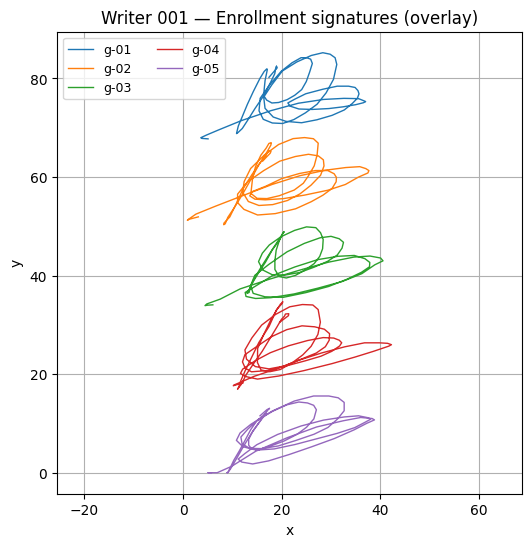

In [ ]:
# overlay enrollment trajectories, shows within-writer variability
fig, ax = plt.subplots(figsize=(6, 6))
for _, row in enroll_rows.sort_values("sig_id").iterrows():
    df = load_sig_from_row(row)
    ax.plot(df["x"], df["y"], linewidth=1, label=f"g-{row['sig_id']}")
ax.set_aspect("equal", adjustable="datalim")
ax.set_title(f"Writer {WRITER} — Enrollment signatures (overlay)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(ncol=2, fontsize=9)
plt.show()


#### Analysis
### Visual variability inside one writer (Writer 001)
**Enrollment overlay (raw XY):**
The 5 enrollment signatures share a consistent global shape, but their absolute position on the tablet differs (translation / placement variability). This suggests that raw coordinates include nuisance variability unrelated to identity, so later we should normalize (centering/scaling) before distance-based matching.


### Genuine vs forgery: side-by-side visuals

In [15]:
# Pick one genuine and one forgery example from verification for this writer
g_row = verif_rows[verif_rows["y"] == 1].sort_values("sig_id").iloc[0]
f_row = verif_rows[verif_rows["y"] == 0].sort_values("sig_id").iloc[0]

g_df = load_sig_from_row(g_row)
f_df = load_sig_from_row(f_row)

print("Genuine example:", f"{WRITER}-{g_row['sig_id']}", "| stats:", compute_stats(g_df))
print("Forgery example:", f"{WRITER}-{f_row['sig_id']}", "| stats:", compute_stats(f_df))


Genuine example: 001-01 | stats: SigStats(n=103, duration=1.02, path_len=265.1030309242293, mean_pressure=756.0679611650486, strokes=1)
Forgery example: 001-03 | stats: SigStats(n=221, duration=2.2, path_len=240.06839609376826, mean_pressure=519.0361990950227, strokes=1)


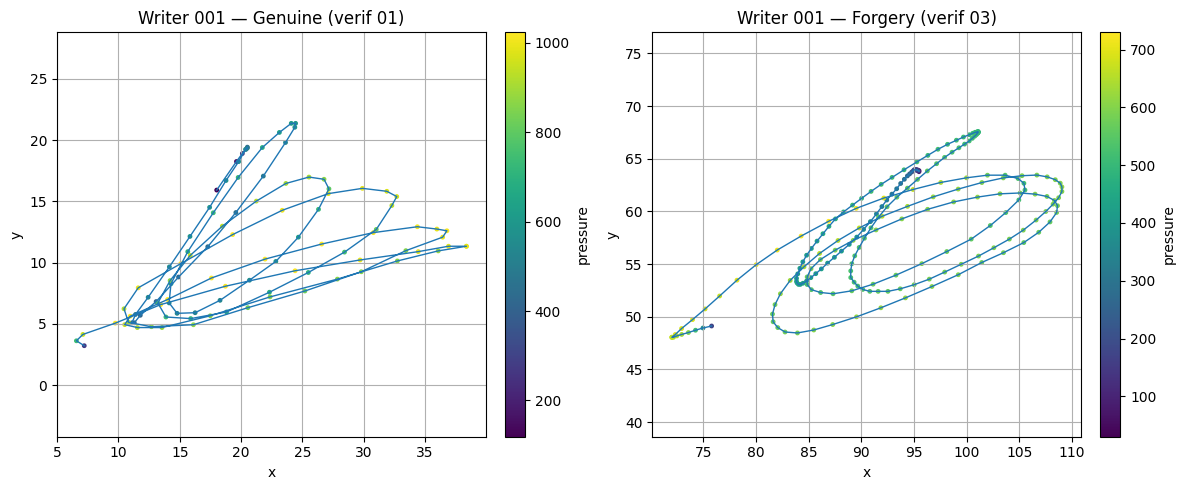

In [ ]:
# XY comparison with pressure-colored
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_xy(g_df, ax=axes[0], color_by="pressure", title=f"Writer {WRITER} — Genuine (verif {g_row['sig_id']})")
plot_xy(f_df, ax=axes[1], color_by="pressure", title=f"Writer {WRITER} — Forgery (verif {f_row['sig_id']})")

plt.tight_layout()
plt.show()


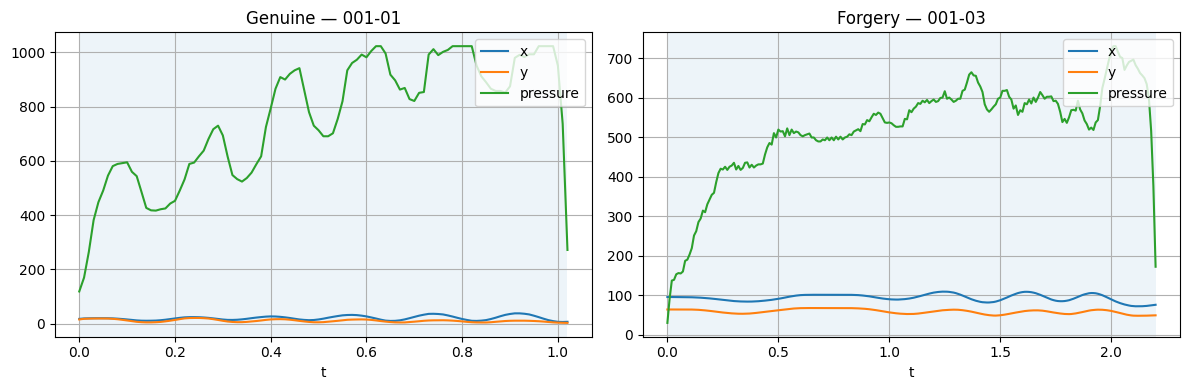

In [ ]:
# time-series comparison (x(t), y(t), pressure(t)) 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_timeseries(g_df, ax=axes[0], title=f"Genuine — {WRITER}-{g_row['sig_id']}")
plot_timeseries(f_df, ax=axes[1], title=f"Forgery — {WRITER}-{f_row['sig_id']}")

plt.tight_layout()
plt.show()


#### Analysis
The genuine and forgery trajectories can look similar in “overall shape”, but they differ in dynamic cues such as pressure evolution and timing.

In this example, the genuine signature shows higher pressure values (peaking around ~1000) while the forgery stays lower (peaking around ~700), and the forgery lasts longer in time.

So even when geometry is close, dynamics (duration, sampling density, pressure) can provide additional separation.


### Global quick stats (do genuines “look” different from forgeries?)

In [ ]:
# computes quick stats for ALL verification signatures (global EDA) 
verif_all = index_df[index_df["split"] == "verification"].copy()

rows = []
for _, row in verif_all.iterrows():
    df = load_sig_from_row(row)
    st = compute_stats(df)
    rows.append({
        "writer_id": row["writer_id"],
        "sig_id": row["sig_id"],
        "y": int(row["y"]),
        "n": st.n,
        "duration": st.duration,
        "path_len": st.path_len,
        "mean_pressure": st.mean_pressure,
        "strokes": st.strokes,
    })

eda_df = pd.DataFrame(rows)
display(eda_df.head())
eda_df.groupby("y")[["n", "duration", "path_len", "mean_pressure", "strokes"]].describe().round(2)


,writer_id,sig_id,y,n,duration,path_len,mean_pressure,strokes
0,001,01,1,103,1.02,265.103031,756.067961,1
1,001,02,1,101,1.00,257.815979,701.297030,1
2,001,03,0,221,2.20,240.068396,519.036199,1
3,001,04,0,225,2.24,185.434864,1004.422222,1
4,001,05,1,106,1.05,264.338474,714.575472,1


n                                                      duration                                            path_len          \
   count    mean     std   min     25%    50%     75%     max    count  mean   std   min   25%   50%   75%    max    count    mean   
y                                                                                                                                    
0  750.0  437.51  345.57  50.0  176.00  361.0  616.00  2689.0    750.0  4.37  3.46  0.49  1.75  3.60  6.15  26.88    750.0  224.82   
1  600.0  288.45  189.64  36.0  132.75  239.5  409.25   969.0    600.0  2.87  1.90  0.35  1.32  2.38  4.08   9.68    600.0  218.02   

                                                 mean_pressure                                                          strokes        \
      std    min     25%     50%     75%     max         count    mean     std     min     25%     50%     75%      max   count  mean   
y                                                                                                                                       
0  105.52  49.66  142.42  211.26  296.09  511.51         750.0  485.74  201.20  141.76  327.87  451.14  614.14  1006.16   750.0  5.85   
1   92.73  84.28  145.96  202.21  269.78  640.97         600.0  550.78  208.55  149.01  379.49  523.37  697.09  1020.72   600.0  5.40   

                                   
    std  min  25%  50%  75%   max  
y                                  
0  5.81  1.0  1.0  3.0  9.0  29.0  
1  5.02  1.0  1.0  4.0  9.0  19.0

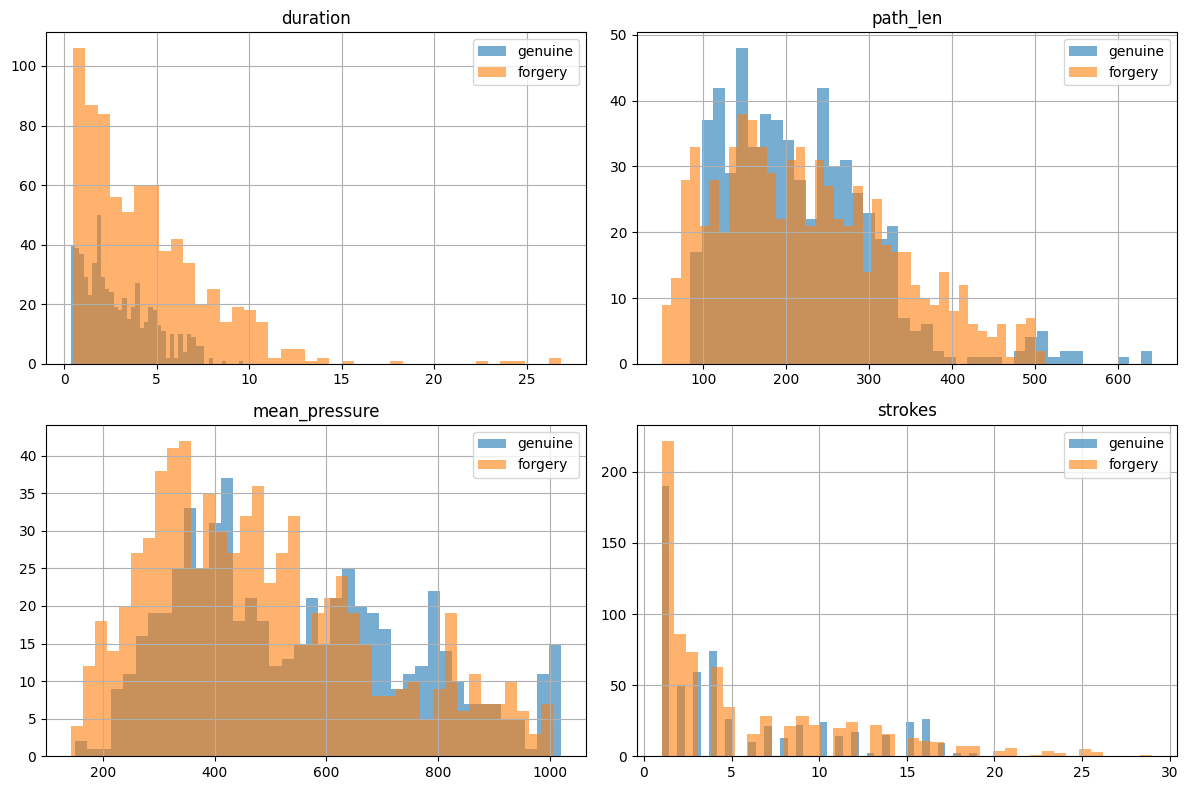

In [ ]:
# distribution plots (genuine vs forgery) 
features = ["duration", "path_len", "mean_pressure", "strokes"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, feat in zip(axes, features):
    ax.hist(eda_df.loc[eda_df["y"] == 1, feat], bins=40, alpha=0.6, label="genuine")
    ax.hist(eda_df.loc[eda_df["y"] == 0, feat], bins=40, alpha=0.6, label="forgery")
    ax.set_title(feat)
    ax.legend()

plt.tight_layout()
plt.show()


#### Analysis

The histograms and summary statistics show consistent trends (with overlap):

- **Duration:** forgeries are longer on average than genuine.
- **Number of points `n`:** forgeries contain more samples than genuine, consistent with longer/slower execution.
- **Mean pressure:** genuine signatures have higher average pressure than forgeries on average.
- **Path length:** distributions overlap strongly, so geometry alone is not always sufficient.
- **Strokes:** wide spread in both classes, not a strong separator by itself.

Simple summary features already show some separation (especially duration/`n`/pressure), but with substantial overlap.

## 3. Preprocessing (Make signatures comparable)

### Preprocessing functions

In [ ]:
def select_pen_down(df: pd.DataFrame, use_pressure: bool = True) -> pd.DataFrame:
    """
    Keep only pen-down samples.
    - If use_pressure=True: pen-down = pressure > 0
    - Else: use 'penup' column (assumes 1=pen-up, 0=pen-down in many datasets)
    """
    if use_pressure:
        out = df[df["pressure"] > 0].copy()
    else:
        out = df[df["penup"] == 0].copy()

    # If filtering removes too much (edge cases), fall back to original
    if len(out) < 5:
        return df.copy()
    return out.reset_index(drop=True)


def normalize_xy(df: pd.DataFrame, mode: str = "center_scale") -> pd.DataFrame:
    """
    Normalize x,y to reduce nuisance variability.
    mode:
      - "none": do nothing
      - "center": subtract mean (translation invariance)
      - "center_scale": center + scale to unit std (or bbox fallback)
    """
    out = df.copy()
    x = out["x"].to_numpy()
    y = out["y"].to_numpy()

    if mode == "none":
        return out

    # Centering
    x = x - np.mean(x)
    y = y - np.mean(y)

    if mode == "center":
        out["x"], out["y"] = x, y
        return out

    # Scaling
    sx = np.std(x)
    sy = np.std(y)
    scale = float(np.sqrt(sx*sx + sy*sy))

    if scale < 1e-8:
        # bbox fallback
        bx = np.max(x) - np.min(x)
        by = np.max(y) - np.min(y)
        scale = float(np.sqrt(bx*bx + by*by)) if (bx > 0 or by > 0) else 1.0

    out["x"] = x / scale
    out["y"] = y / scale
    return out


def time_normalize(df: pd.DataFrame) -> pd.DataFrame:
    """
    Map t to [0,1] to make interpolation stable across signatures.
    """
    out = df.copy()
    t = out["t"].to_numpy()
    t0, t1 = float(t[0]), float(t[-1])
    denom = (t1 - t0) if (t1 > t0) else 1.0
    out["t"] = (t - t0) / denom
    return out


def resample_signature(df: pd.DataFrame, N: int = 200, cols=("x","y","pressure")) -> pd.DataFrame:
    """
    Resample selected columns to N points using linear interpolation over normalized time.
    Assumes df['t'] is already in [0,1] and sorted.
    """
    if len(df) < 2:
        return df.copy()

    t = df["t"].to_numpy()
    t_new = np.linspace(0.0, 1.0, N)

    out = pd.DataFrame({"t": t_new})
    for c in cols:
        v = df[c].to_numpy()
        out[c] = np.interp(t_new, t, v)

    return out


### One “pipeline” function (what we’ll reuse everywhere)

In [21]:
def preprocess(df: pd.DataFrame,
               pen_down: bool = True,
               norm_mode: str = "center_scale",
               N: int = 200) -> pd.DataFrame:
    out = df.copy()
    if pen_down:
        out = select_pen_down(out, use_pressure=True)

    out = out.sort_values("t").reset_index(drop=True)
    out = time_normalize(out)
    out = normalize_xy(out, mode=norm_mode)
    out = resample_signature(out, N=N, cols=("x","y","pressure"))
    return out


### Quick visual check: before vs after (same signature)

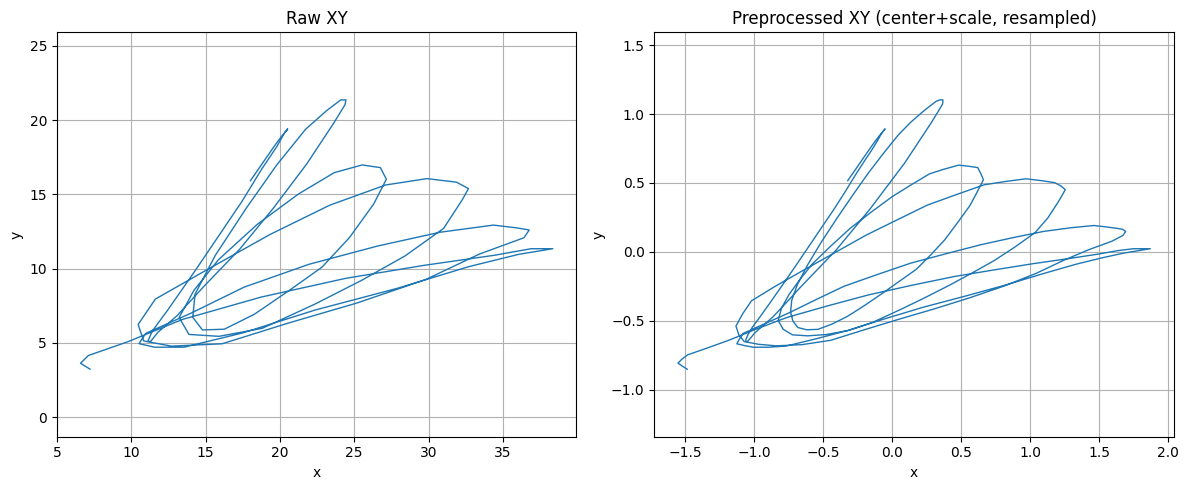

In [22]:
row = get_sig_row("001", "verification", "01")
raw = load_sig_from_row(row)
proc = preprocess(raw, pen_down=True, norm_mode="center_scale", N=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_xy(raw,  ax=axes[0], color_by=None, title="Raw XY")
plot_xy(proc, ax=axes[1], color_by=None, title="Preprocessed XY (center+scale, resampled)")
plt.tight_layout()
plt.show()


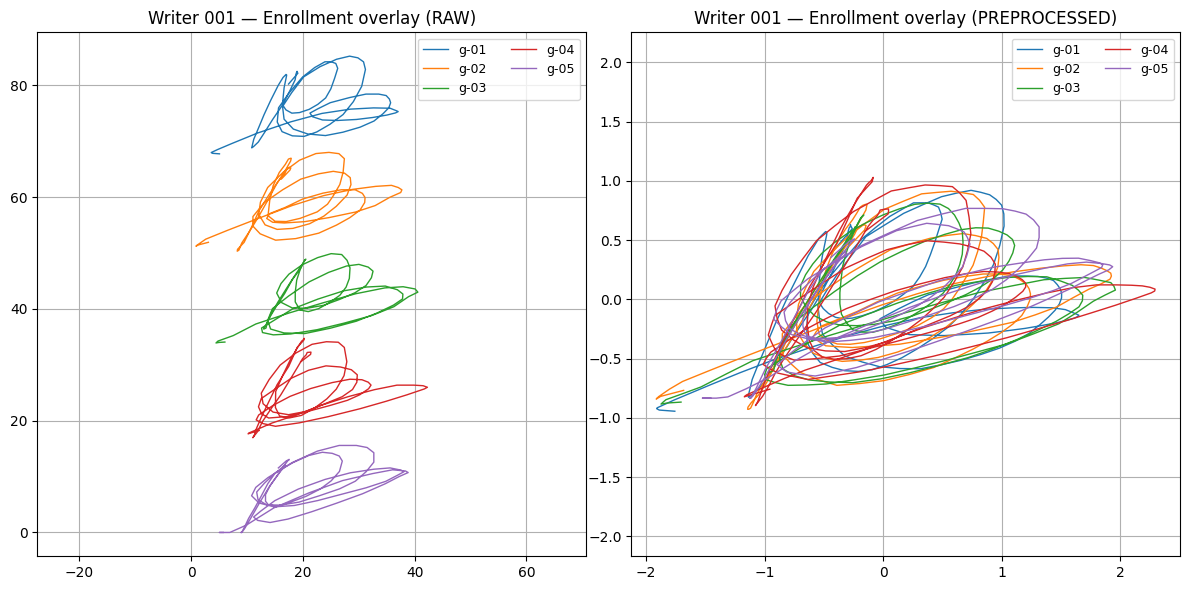

In [23]:
WRITER = "001"

enroll_rows = index_df[(index_df["writer_id"] == WRITER) & (index_df["split"] == "enrollment")].copy()
enroll_rows = enroll_rows.sort_values("sig_id")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Raw overlay
for _, row in enroll_rows.iterrows():
    df = load_sig_from_row(row)
    axes[0].plot(df["x"], df["y"], linewidth=1, label=f"g-{row['sig_id']}")
axes[0].set_title(f"Writer {WRITER} — Enrollment overlay (RAW)")
axes[0].set_aspect("equal", adjustable="datalim")
axes[0].legend(ncol=2, fontsize=9)

# Preprocessed overlay
for _, row in enroll_rows.iterrows():
    df = load_sig_from_row(row)
    dfp = preprocess(df, pen_down=True, norm_mode="center_scale", N=200)
    axes[1].plot(dfp["x"], dfp["y"], linewidth=1, label=f"g-{row['sig_id']}")
axes[1].set_title(f"Writer {WRITER} — Enrollment overlay (PREPROCESSED)")
axes[1].set_aspect("equal", adjustable="datalim")
axes[1].legend(ncol=2, fontsize=9)

plt.tight_layout()
plt.show()


### Analysis

Centering and scaling remove nuisance variability due to where the signature is written on the tablet. After preprocessing, enrollment signatures overlap much more tightly, which is essential for distance-based matching.

We also resample signatures to a fixed length to allow consistent comparison and stable distance computation across samples.


## 4. Baseline verifier (cheap + effective to start)

### 4.1 Build per-writer enrollment templates (cached)

In [ ]:
N_RESAMPLE = 200

@lru_cache(maxsize=None)
def get_enrollment_templates(writer_id: str):
    writer_id = str(writer_id).zfill(3)
    rows = index_df[(index_df["writer_id"] == writer_id) & (index_df["split"] == "enrollment")].sort_values("sig_id")
    templates = []
    for _, r in rows.iterrows():
        df = load_sig_from_row(r)
        dfp = preprocess(df, pen_down=True, norm_mode="center_scale", N=N_RESAMPLE)
        templates.append(dfp[["x","y","pressure"]].to_numpy())
    return templates

def seq_distance(a: np.ndarray, b: np.ndarray) -> float:
    # a,b: shape (N, D)
    return float(np.linalg.norm(a - b))

def score_min_dist(writer_id: str, verif_df: pd.DataFrame) -> float:
    templates = get_enrollment_templates(writer_id)
    q = preprocess(verif_df, pen_down=True, norm_mode="center_scale", N=N_RESAMPLE)[["x","y","pressure"]].to_numpy()
    dists = [seq_distance(q, t) for t in templates]
    return float(np.min(dists))


### 4.2 Compute scores for all verification samples

In [25]:
verif = index_df[index_df["split"] == "verification"].copy()

scores = []
for _, row in verif.iterrows():
    df = load_sig_from_row(row)
    s = score_min_dist(row["writer_id"], df)
    scores.append(s)

verif = verif.reset_index(drop=True)
verif["score"] = scores

display(verif[["writer_id","sig_id","y","score"]].head())


,writer_id,sig_id,y,score
0,001,01,1,1372.517845
1,001,02,1,1073.768492
2,001,03,0,2559.236689
3,001,04,0,4757.366434
4,001,05,1,1623.746200


### 4.3 Visualize separation (lower score = “more similar”)

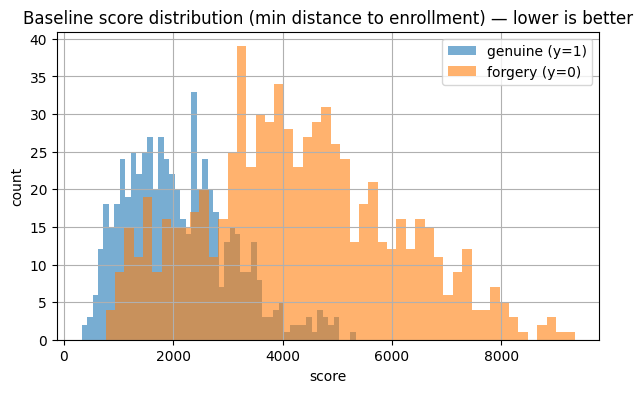

In [26]:
plt.figure(figsize=(7,4))
plt.hist(verif.loc[verif["y"]==1, "score"], bins=50, alpha=0.6, label="genuine (y=1)")
plt.hist(verif.loc[verif["y"]==0, "score"], bins=50, alpha=0.6, label="forgery (y=0)")
plt.title("Baseline score distribution (min distance to enrollment) — lower is better")
plt.xlabel("score")
plt.ylabel("count")
plt.legend()
plt.show()


#### Analysis
The histogram shows that **genuine signatures concentrate at lower distances** than forgeries, which is encouraging.  
However, there is still **substantial overlap** between the two distributions: some forgeries look close to enrollment (low score) and some genuine samples deviate (higher score). This overlap explains why a single global threshold cannot perfectly separate the classes.

### 4.4 ROC AUC + EER (quick evaluation)

ROC AUC: 0.8519
EER:     0.2157
EER threshold (on y_score=-score): -2809.9256


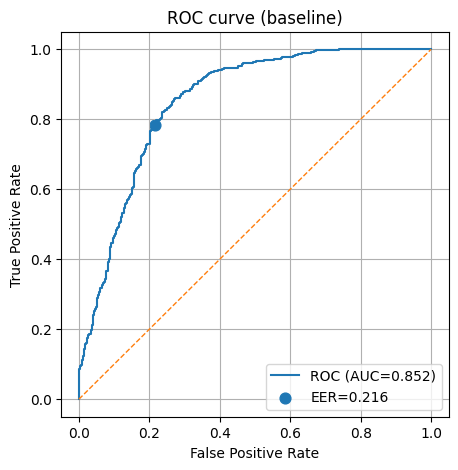

In [ ]:
y_true = verif["y"].astype(int).to_numpy()

# IMPORTANT: since low score = genuine, we invert sign so "higher = more genuine"
y_score = (-verif["score"]).to_numpy()

auc = roc_auc_score(y_true, y_score)
fpr, tpr, thr = roc_curve(y_true, y_score)

fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fpr - fnr))
eer = 0.5 * (fpr[eer_idx] + fnr[eer_idx])
eer_thr = thr[eer_idx]

print(f"ROC AUC: {auc:.4f}")
print(f"EER:     {eer:.4f}")
print(f"EER threshold (on y_score=-score): {eer_thr:.4f}")

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1)

plt.scatter(fpr[eer_idx], tpr[eer_idx], s=60, label=f"EER={eer:.3f}")
plt.title("ROC curve (baseline)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


### 4.5 Confusion matrix at EER threshold

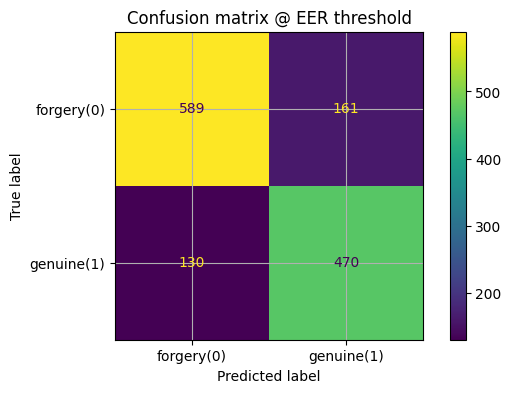

TN=589 FP=161 FN=130 TP=470
FAR (false accept rate)  = FP/(FP+TN) = 0.215
FRR (false reject rate)  = FN/(FN+TP) = 0.217


In [ ]:
eer_score_thr = -eer_thr  # threshold in original score space
y_pred = (verif["score"].to_numpy() <= eer_score_thr).astype(int)  # 1 = genuine

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["forgery(0)", "genuine(1)"])
disp.plot(values_format="d")
plt.title("Confusion matrix @ EER threshold")
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"TN={tn} FP={fp} FN={fn} TP={tp}")
print(f"FAR (false accept rate)  = FP/(FP+TN) = {fp/(fp+tn):.3f}")
print(f"FRR (false reject rate)  = FN/(FN+TP) = {fn/(fn+tp):.3f}")


### 4.6 Per-writer AUC (quick “hard vs easy writers”)

,writer_id,auc
21,022,0.568
28,029,0.622
14,015,0.722
26,027,0.790
22,023,0.806
7,008,0.894
3,004,0.896
6,007,0.916
2,003,0.922
8,009,0.924


,writer_id,auc
11,012,0.986
16,017,0.986
27,028,0.992
24,025,0.992
0,001,0.996
12,013,1.000
5,006,1.000
4,005,1.000
18,019,1.000
29,030,1.000


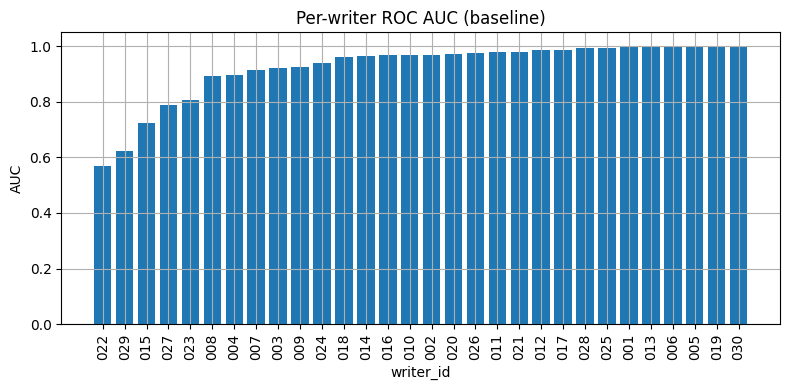

In [ ]:
per_writer = []
for w, g in verif.groupby("writer_id"):
    yt = g["y"].astype(int).to_numpy()
    ys = (-g["score"]).to_numpy()  # higher means more genuine
    # AUC requires both classes present; here it should, but just in case:
    if len(np.unique(yt)) < 2:
        continue
    per_writer.append({"writer_id": w, "auc": roc_auc_score(yt, ys)})

per_writer_df = pd.DataFrame(per_writer).sort_values("auc")
display(per_writer_df.head(10))
display(per_writer_df.tail(10))

plt.figure(figsize=(8,4))
plt.bar(per_writer_df["writer_id"], per_writer_df["auc"])
plt.xticks(rotation=90)
plt.title("Per-writer ROC AUC (baseline)")
plt.xlabel("writer_id")
plt.ylabel("AUC")
plt.tight_layout()
plt.show()


### Analysis
The Euclidean template baseline provides a reasonable starting point but shows clear limitations. While it separates genuine and forgery distributions, the overlap remains significant (AUC ≈ 0.852, EER ≈ 0.216).

The per-writer AUC plot shows strong heterogeneity: many writers are close to perfect (AUC near 1.0), while a few writers are clearly harder (e.g., **writer 022** is the worst in this run).

This indicates the baseline works well when a writer has **stable, consistent signing**, but struggles when:
- the writer’s genuine signatures vary a lot (high intra-writer variability), or
- the forgeries are visually close to the enrollment templates.

Euclidean template matching is a solid baseline, but it is sensitive to timing/trajectory misalignment and writer-specific variability — motivating DTW and more flexible decision rules in later steps.


## 5. DTW

### 5.1 DTW distance (banded, multivariate)

In [32]:
def dtw_distance(a: np.ndarray, b: np.ndarray, band: int = 20) -> float:
    """
    Banded DTW for sequences a,b of shape (N,D), same N.
    band: max |i-j| allowed (Sakoe–Chiba). Smaller = faster/less warping.
    Uses L2 local cost.
    """
    N = a.shape[0]
    assert b.shape[0] == N, "This DTW assumes same length after resampling."

    INF = 1e18
    dp = np.full((N + 1, N + 1), INF, dtype=np.float64)
    dp[0, 0] = 0.0

    for i in range(1, N + 1):
        j0 = max(1, i - band)
        j1 = min(N, i + band)
        for j in range(j0, j1 + 1):
            cost = np.linalg.norm(a[i-1] - b[j-1])
            dp[i, j] = cost + min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1])

    return float(dp[N, N])


### 5.2 DTW score = min DTW distance to 5 enrollment templates

In [33]:
def score_min_dtw(writer_id: str, verif_df: pd.DataFrame, band: int = 20) -> float:
    templates = get_enrollment_templates(writer_id)  # already preprocessed (N_RESAMPLE)
    q = preprocess(verif_df, pen_down=True, norm_mode="center_scale", N=N_RESAMPLE)[["x","y","pressure"]].to_numpy()
    dists = [dtw_distance(q, t, band=band) for t in templates]
    return float(np.min(dists))


### 5.3 Compute DTW scores (start with a small subset to sanity-check)

In [34]:
# Quick sanity check on a subset (e.g. 200 samples) before full run
verif = index_df[index_df["split"] == "verification"].copy().reset_index(drop=True)

subset = verif.sample(n=200, random_state=42).copy()

band = 20
dtw_scores = []
for _, row in subset.iterrows():
    df = load_sig_from_row(row)
    dtw_scores.append(score_min_dtw(row["writer_id"], df, band=band))

subset["dtw_score"] = dtw_scores
display(subset[["writer_id","sig_id","y","dtw_score"]].head())


,writer_id,sig_id,y,dtw_score
289,007,20,0,26306.990200
1036,024,02,1,10495.334264
535,012,41,1,14798.575737
346,008,32,0,19012.581189
1075,024,41,0,55530.226957


### 5.4 Evaluate subset AUC quickly

In [ ]:
y_true_sub = subset["y"].astype(int).to_numpy()
y_score_sub = (-subset["dtw_score"]).to_numpy()  # lower dist => more genuine

print("Subset ROC AUC (DTW):", roc_auc_score(y_true_sub, y_score_sub))


Subset ROC AUC (DTW): 0.9400749063670412


In [37]:
band = 20
dtw_scores = []
for _, row in verif.iterrows():
    df = load_sig_from_row(row)
    dtw_scores.append(score_min_dtw(row["writer_id"], df, band=band))

verif["dtw_score"] = dtw_scores


In [38]:
y_true = verif["y"].astype(int).to_numpy()
y_score = (-verif["dtw_score"]).to_numpy()

auc_dtw = roc_auc_score(y_true, y_score)
fpr, tpr, thr = roc_curve(y_true, y_score)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fpr - fnr))
eer_dtw = 0.5 * (fpr[eer_idx] + fnr[eer_idx])

print(f"DTW ROC AUC: {auc_dtw:.4f}")
print(f"DTW EER:     {eer_dtw:.4f}")


DTW ROC AUC: 0.9077
DTW EER:     0.1630


### 5.5 per-writer AUC comparison: baseline vs DTW

In [ ]:
verif_base = index_df[index_df["split"] == "verification"].copy().reset_index(drop=True)

scores = []
for _, row in verif_base.iterrows():
    df = load_sig_from_row(row)
    scores.append(score_min_dist(row["writer_id"], df))  # Euclidean baseline

verif_base["baseline_score"] = scores

verif_dtw = verif[["writer_id", "sig_id", "dtw_score"]].copy()
verif_all = verif_base.merge(verif_dtw, on=["writer_id", "sig_id"], how="inner")

display(verif_all.head())


,split,writer_id,sig_id,path,label,is_genuine,y,baseline_score,dtw_score
0,verification,001,01,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,1.0,True,1,1372.517845,6289.341344
1,verification,001,02,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,1.0,True,1,1073.768492,4590.575855
2,verification,001,03,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,0.0,False,0,2559.236689,24571.946575
3,verification,001,04,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,0.0,False,0,4757.366434,45203.127906
4,verification,001,05,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,1.0,True,1,1623.746200,5173.562917


,writer_id,auc_euclid,auc_dtw,delta
4,005,1.000,0.938,-0.062
7,008,0.894,0.848,-0.046
22,023,0.806,0.766,-0.040
23,024,0.938,0.908,-0.030
13,014,0.966,0.942,-0.024
28,029,0.622,0.602,-0.020
9,010,0.968,0.950,-0.018
29,030,1.000,0.988,-0.012
20,021,0.978,0.976,-0.002
26,027,0.790,0.788,-0.002


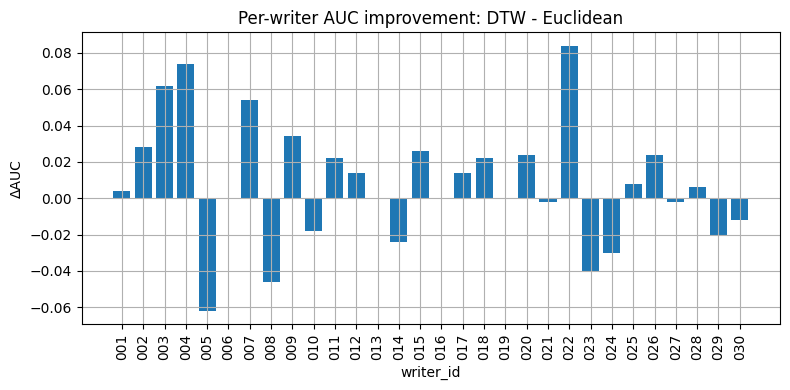

In [44]:
def per_writer_auc(df_scores: pd.DataFrame, score_col: str) -> pd.DataFrame:
    rows = []
    for w, g in df_scores.groupby("writer_id"):
        yt = g["y"].astype(int).to_numpy()
        ys = (-g[score_col]).to_numpy()
        if len(np.unique(yt)) < 2:
            continue
        rows.append({"writer_id": w, "auc": roc_auc_score(yt, ys)})
    return pd.DataFrame(rows).sort_values("writer_id").reset_index(drop=True)

baseline_auc = per_writer_auc(verif_all.rename(columns={"score":"baseline_score"}), "baseline_score")
dtw_auc      = per_writer_auc(verif_all, "dtw_score")

cmp = baseline_auc.merge(dtw_auc, on="writer_id", suffixes=("_euclid", "_dtw"))
cmp["delta"] = cmp["auc_dtw"] - cmp["auc_euclid"]
display(cmp.sort_values("delta").head(10))

plt.figure(figsize=(8,4))
plt.bar(cmp["writer_id"], cmp["delta"])
plt.xticks(rotation=90)
plt.title("Per-writer AUC improvement: DTW - Euclidean")
plt.xlabel("writer_id")
plt.ylabel("ΔAUC")
plt.tight_layout()
plt.show()


This bar plot shows, for each writer, how much the ROC AUC changes when switching from Euclidean to DTW (deltaAUC = AUC_DTW − AUC_Euclid). Bars above 0 mean DTW improved that writer, bars below 0 mean DTW made it worse.

Most writers are slightly above 0, so DTW gives small improvements for many of them. A few writers show large gains: the biggest positive bar is around writer 022 (about +0.08), and writers 003–005 also have noticeable improvements (around +0.06 to +0.07). 

There are also some clear negative cases. The largest drop is around writer 006 (about −0.06), and writers 008, 023 and 024 also decrease (roughly −0.03 to −0.05). Several writers are very close to 0, meaning DTW does not change much compared to Euclidean for them.

Overall, the graph shows that DTW usually helps, but the effect is writer-dependent: it can strongly improve some writers while slightly harming a small subset.


In [ ]:
# to test later
"""for band in [10, 15, 20]:
    dtw_scores = []
    for _, row in verif.iterrows():
        df = load_sig_from_row(row)
        dtw_scores.append(score_min_dtw(row["writer_id"], df, band=band))
    verif_tmp = verif.copy()
    verif_tmp["dtw_score"] = dtw_scores

    y_true = verif_tmp["y"].astype(int).to_numpy()
    y_score = (-verif_tmp["dtw_score"]).to_numpy()
    auc = roc_auc_score(y_true, y_score)

    fpr, tpr, thr = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fpr - fnr))
    eer = 0.5 * (fpr[eer_idx] + fnr[eer_idx])

    print(f"band={band:2d} | AUC={auc:.4f} | EER={eer:.4f}")
"""

## 6. Writer-dependent thresholding (calibration)

### 6.1 Compute writer-specific thresholds from enrollment (leave-one-out)

In [ ]:
def enrollment_loo_scores(writer_id: str, metric: str = "dtw", band: int = 20) -> np.ndarray:
    """
    Compute leave-one-out genuine variability from enrollment:
      for each enrollment template i, distance(template_i, closest other template).
    metric: "dtw" or "euclid"
    """
    templates = get_enrollment_templates(writer_id)  # list of arrays (N,D) already preprocessed

    scores = []
    for i in range(len(templates)):
        a = templates[i]
        dists = []
        for j in range(len(templates)):
            if i == j:
                continue
            b = templates[j]
            if metric == "dtw":
                d = dtw_distance(a, b, band=band)
            elif metric == "euclid":
                d = float(np.linalg.norm(a - b))
            else:
                raise ValueError("metric must be 'dtw' or 'euclid'")
            dists.append(d)
        scores.append(min(dists))
    return np.asarray(scores, dtype=float)


def writer_thresholds(index_df: pd.DataFrame, metric: str = "dtw", band: int = 20, q: float = 0.95) -> pd.DataFrame:
    """
    Build per-writer thresholds using enrollment LOO distances.
    threshold_w = quantile_q(LOO distances)
    """
    writers = sorted(index_df["writer_id"].unique())
    rows = []
    for w in writers:
        loo = enrollment_loo_scores(w, metric=metric, band=band)
        thr = float(np.quantile(loo, q))
        rows.append({
            "writer_id": w,
            "thr": thr,
            "loo_mean": float(np.mean(loo)),
            "loo_std": float(np.std(loo)),
            "loo_vals": loo,  # keep for inspection if needed
        })
    return pd.DataFrame(rows)

# Choose which metric to calibrate on:
CALIB_METRIC = "dtw"   # "dtw" recommended since it's our best distance now
BAND = 20
Q = 0.90

thr_df = writer_thresholds(index_df, metric=CALIB_METRIC, band=BAND, q=Q)
display(thr_df[["writer_id", "thr", "loo_mean", "loo_std"]].head())


,writer_id,thr,loo_mean,loo_std
0,001,4600.269755,3763.542658,716.359382
1,002,6885.205394,4488.897587,2412.734048
2,003,12521.302683,11698.971793,686.530081
3,004,7826.238985,6385.040371,1442.226248
4,005,7238.143767,5812.576084,1353.115492


### 6.2 Apply writer thresholds to verification and evaluate

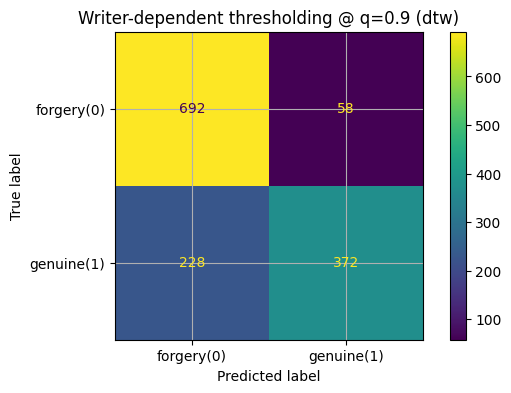

TN=692 FP=58 FN=228 TP=372
FAR = 0.077 | FRR = 0.380 | Acc = 0.788


In [ ]:
# Starts from a DF that has the verification scores we want to threshold.
# If verif_all is already with "dtw_score" and/or "baseline_score", use that.
# Here we'll build a fresh verification DF from index_df and attach dtw_score if present.

verif_cal = index_df[index_df["split"] == "verification"].copy().reset_index(drop=True)

# Attaches the score column to threshold on:
# - If verif["dtw_score"] already computed  earlier, merge it in.
# - Otherwise we recompute it here.

if "dtw_score" in verif.columns:
    verif_cal = verif_cal.merge(verif[["writer_id", "sig_id", "dtw_score"]], on=["writer_id","sig_id"], how="left")
    score_col = "dtw_score"
else:
    # Fallback: compute DTW score (min DTW to enrollment) now
    dtw_scores = []
    for _, row in verif_cal.iterrows():
        df = load_sig_from_row(row)
        dtw_scores.append(score_min_dtw(row["writer_id"], df, band=BAND))
    verif_cal["dtw_score"] = dtw_scores
    score_col = "dtw_score"

# Merge thresholds
verif_cal = verif_cal.merge(thr_df[["writer_id", "thr"]], on="writer_id", how="left")

# Predict
verif_cal["y_true"] = verif_cal["y"].astype(int)
verif_cal["y_pred"] = (verif_cal[score_col] <= verif_cal["thr"]).astype(int)

# Confusion + FAR/FRR
cm = confusion_matrix(verif_cal["y_true"], verif_cal["y_pred"], labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=["forgery(0)", "genuine(1)"])
disp.plot(values_format="d")
plt.title(f"Writer-dependent thresholding @ q={Q} ({CALIB_METRIC})")
plt.show()

tn, fp, fn, tp = cm.ravel()
far = fp / (fp + tn)
frr = fn / (fn + tp)
acc = (tp + tn) / (tp + tn + fp + fn)

print(f"TN={tn} FP={fp} FN={fn} TP={tp}")
print(f"FAR = {far:.3f} | FRR = {frr:.3f} | Acc = {acc:.3f}")


This confusion matrix shows the result of writer-dependent thresholding using DTW scores with q = 0.9.

Most forgeries are correctly rejected: 692 are classified as forgery, and only 58 forgeries are incorrectly accepted as genuine. This gives a low false accept rate (FAR = 0.077), so the method is quite strict against accepting impostors.

On the other hand, many genuine signatures are rejected: 372 genuine are accepted, but 228 genuine are incorrectly classified as forgery. This gives a high false reject rate (FRR = 0.380), meaning the method often refuses real users.

So the graph shows a clear trade-off: with this per-writer threshold setting, the system prioritizes security (few false accepts) at the cost of usability (more false rejects). The overall accuracy here is 0.788, but the errors are mostly coming from rejecting genuine samples rather than accepting forgeries.


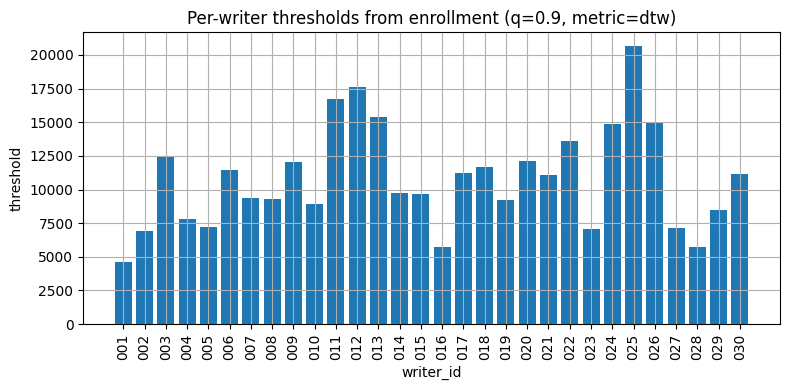

In [55]:
plt.figure(figsize=(8,4))
plt.bar(thr_df["writer_id"], thr_df["thr"])
plt.xticks(rotation=90)
plt.title(f"Per-writer thresholds from enrollment (q={Q}, metric={CALIB_METRIC})")
plt.xlabel("writer_id")
plt.ylabel("threshold")
plt.tight_layout()
plt.show()


This bar plot shows the DTW threshold computed separately for each writer from the 5 enrollment signatures (using q = 0.9). Each bar is the maximum “normal” distance we allow for that writer before rejecting a query.

The thresholds vary a lot across writers. Some writers have low thresholds (around a few thousand), meaning their enrollment signatures are very consistent and even small deviations look suspicious. Other writers have much higher thresholds (going up to around twenty thousand), meaning their enrollment signatures are more variable, so the system has to allow larger DTW distances to avoid rejecting genuine samples.

So the graph mainly shows that a single global threshold would not fit everyone well, and that writer-dependent calibration adapts the accept/reject boundary to each writer’s natural variability.


## 7. Global classifier on engineered features (GroupKFold by writer)

### 7.1 Build the feature table

In [ ]:
def euclid_to_templates(writer_id: str, sig_df: pd.DataFrame) -> np.ndarray:
    """
    Returns Euclidean distances to each of the 5 enrollment templates (after preprocessing).
    """
    templates = get_enrollment_templates(writer_id)  # list of (N,D)
    q = preprocess(sig_df, pen_down=True, norm_mode="center_scale", N=N_RESAMPLE)[["x","y","pressure"]].to_numpy()
    return np.asarray([float(np.linalg.norm(q - t)) for t in templates], dtype=float)


def compute_global_features(sig_df: pd.DataFrame) -> dict:
    st = compute_stats(sig_df)  # uses raw df stats
    return {
        "n": st.n,
        "duration": st.duration,
        "path_len": st.path_len,
        "mean_pressure": st.mean_pressure,
        "strokes": st.strokes,
    }


# Start from verification index
feat_df = index_df[index_df["split"] == "verification"].copy().reset_index(drop=True)

# Attach dtw_score if available (recommended)
if "dtw_score" in verif.columns:
    feat_df = feat_df.merge(verif[["writer_id","sig_id","dtw_score"]], on=["writer_id","sig_id"], how="left")
else:
    # If not present, compute it (min DTW) once
    dtw_scores = []
    for _, row in feat_df.iterrows():
        df = load_sig_from_row(row)
        dtw_scores.append(score_min_dtw(row["writer_id"], df, band=BAND))
    feat_df["dtw_score"] = dtw_scores

# Extract features
rows = []
for _, row in feat_df.iterrows():
    df = load_sig_from_row(row)

    d_e = euclid_to_templates(row["writer_id"], df)  # 5 values
    gf = compute_global_features(df)

    r = {
        "writer_id": row["writer_id"],
        "sig_id": row["sig_id"],
        "y": int(row["y"]),
        "dtw_score": float(row["dtw_score"]),
        # Euclid distances to each enrollment template
        "e1": d_e[0], "e2": d_e[1], "e3": d_e[2], "e4": d_e[3], "e5": d_e[4],
        # Aggregates
        "e_min": float(np.min(d_e)),
        "e_mean": float(np.mean(d_e)),
        "e_std": float(np.std(d_e)),
        **gf,
    }
    rows.append(r)

Xy = pd.DataFrame(rows)
display(Xy.head())
print("Rows:", len(Xy), "| Positives (genuine=1):", int(Xy["y"].sum()))


,writer_id,sig_id,y,dtw_score,e1,e2,e3,e4,e5,e_min,e_mean,e_std,n,duration,path_len,mean_pressure,strokes
0,001,01,1,6289.341344,1539.780977,1456.989290,1560.439429,1372.517845,1623.168218,1372.517845,1510.579152,87.118183,103,1.02,265.103031,756.067961,1
1,001,02,1,4590.575855,1511.517409,1073.768492,1160.489556,1232.719904,1292.601347,1073.768492,1254.219342,147.976675,101,1.00,257.815979,701.297030,1
2,001,03,0,24571.946575,2973.829345,3033.317246,2822.815414,3348.835011,2559.236689,2559.236689,2947.606741,259.006646,221,2.20,240.068396,519.036199,1
3,001,04,0,45203.127906,4818.616318,4977.709936,5094.647566,4757.366434,5455.698780,4757.366434,5020.807807,247.678279,225,2.24,185.434864,1004.422222,1
4,001,05,1,5173.562917,1623.746200,1714.669240,1668.661616,1712.595793,1638.788673,1623.746200,1671.692305,37.177346,106,1.05,264.338474,714.575472,1


Rows: 1350 | Positives (genuine=1): 600


### 7.2 Train/evaluate with GroupKFold (by writer)

GroupKFold OOF ROC AUC: 0.9179
GroupKFold OOF EER:     0.1615


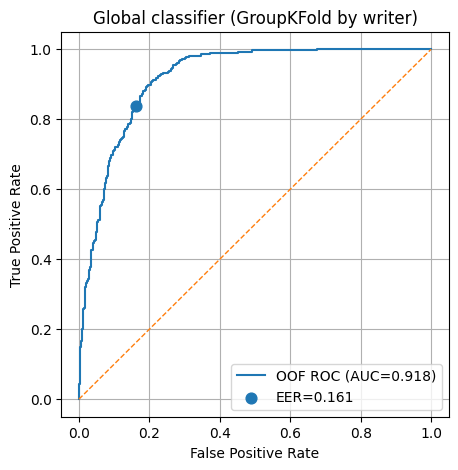

In [ ]:
# Features (exclude IDs + label)
feature_cols = [
    "dtw_score",
    "e1","e2","e3","e4","e5","e_min","e_mean","e_std",
    "n","duration","path_len","mean_pressure","strokes",
]

X = Xy[feature_cols].to_numpy()
y = Xy["y"].to_numpy().astype(int)
groups = Xy["writer_id"].to_numpy()

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

gkf = GroupKFold(n_splits=5)

# Out-of-fold predicted probabilities for class 1
proba_oof = np.zeros(len(X), dtype=float)

for train_idx, test_idx in gkf.split(X, y, groups=groups):
    clf.fit(X[train_idx], y[train_idx])
    proba_oof[test_idx] = clf.predict_proba(X[test_idx])[:, 1]

auc = roc_auc_score(y, proba_oof)
fpr, tpr, thr = roc_curve(y, proba_oof)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fpr - fnr))
eer = 0.5 * (fpr[eer_idx] + fnr[eer_idx])

print(f"GroupKFold OOF ROC AUC: {auc:.4f}")
print(f"GroupKFold OOF EER:     {eer:.4f}")

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"OOF ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--", linewidth=1)
plt.scatter(fpr[eer_idx], tpr[eer_idx], s=60, label=f"EER={eer:.3f}")
plt.title("Global classifier (GroupKFold by writer)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


7.3 See which features matter most (logistic regression coefficients)

In [58]:
# Fit on full data to inspect coefficients (NOTE: for interpretation only)
clf.fit(X, y)
coefs = clf.named_steps["lr"].coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_cols, "coef": coefs}).sort_values("coef", ascending=False)
display(coef_df)


,feature,coef
3,e3,1.603924
13,strokes,1.462179
11,path_len,1.148782
8,e_std,0.450768
12,mean_pressure,0.252658
6,e_min,0.059973
7,e_mean,-0.083639
2,e2,-0.398053
5,e5,-0.455915
4,e4,-0.587771


Step 7.2 shows the ROC curve of the global classifier evaluated with GroupKFold by writer (out-of-fold predictions). The curve is far above the diagonal line and rises quickly toward the top-left, which means the classifier reaches high true positive rates while keeping false positives relatively low.

The printed metrics match the shape of the curve:
* ROC AUC is 0.9179, which indicates strong separation between genuine and forgery scores.
* EER is 0.1615, and the dot on the curve marks the operating point where FAR and FRR are equal, at a noticeably lower error rate than the baseline.

Because folds are split by writer, these scores reflect performance on writers not seen during training, so the result is not coming from memorizing writer identities.


## 8. Evaluation & reporting

### 8.1 Build one evaluation dataframe (single source for evaluation)

In [ ]:
eval_df = verif_all.merge(thr_df[["writer_id","thr"]], on="writer_id", how="left")

# Writer-threshold "margin score": >0 predicts genuine
eval_df["thr_margin"] = eval_df["thr"] - eval_df["dtw_score"]

# Attach classifier OOF probabilities
clf_df = Xy[["writer_id","sig_id"]].copy()
clf_df["clf_proba"] = proba_oof
eval_df = eval_df.merge(clf_df, on=["writer_id","sig_id"], how="left")

display(eval_df.head())
print("Rows:", len(eval_df), "| positives:", int(eval_df["y"].sum()))


def roc_eer(y_true: np.ndarray, y_score: np.ndarray):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    i = np.nanargmin(np.abs(fpr - fnr))
    eer = 0.5 * (fpr[i] + fnr[i])
    return dict(fpr=fpr, tpr=tpr, thr=thr, eer=eer, eer_thr=thr[i])


def summarize_method(name: str, y_true, score, higher_is_genuine=True):
    y_true = np.asarray(y_true).astype(int)
    score = np.asarray(score).astype(float)

    if not higher_is_genuine:
        score = -score

    out = roc_eer(y_true, score)
    auc = roc_auc_score(y_true, score)

    # predictions @ EER threshold
    y_pred = (score >= out["eer_thr"]).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    far = fp/(fp+tn) if (fp+tn) else np.nan
    frr = fn/(fn+tp) if (fn+tp) else np.nan
    acc = (tp+tn)/(tp+tn+fp+fn)

    return dict(
        method=name,
        auc=auc,
        eer=out["eer"],
        eer_thr=out["eer_thr"],
        tn=tn, fp=fp, fn=fn, tp=tp,
        far=far, frr=frr, acc=acc,
        _roc=out, _score=score, _y_true=y_true
    )


,split,writer_id,sig_id,path,label,is_genuine,y,baseline_score,dtw_score,thr,thr_margin,clf_proba
0,verification,001,01,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,1.0,True,1,1372.517845,6289.341344,4600.269755,-1689.071589,0.963187
1,verification,001,02,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,1.0,True,1,1073.768492,4590.575855,4600.269755,9.693900,0.968982
2,verification,001,03,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,0.0,False,0,2559.236689,24571.946575,4600.269755,-19971.676820,0.119813
3,verification,001,04,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,0.0,False,0,4757.366434,45203.127906,4600.269755,-40602.858151,0.002667
4,verification,001,05,c:\Users\aqual\Desktop\M\Pattern Recognition\P...,1.0,True,1,1623.746200,5173.562917,4600.269755,-573.293162,0.955903


Rows: 1350 | positives: 600


### 8.2 Global metrics table

In [ ]:
methods = []
methods.append(summarize_method("Baseline (Euclid)", eval_df["y"], eval_df["baseline_score"], higher_is_genuine=False))
methods.append(summarize_method("DTW",              eval_df["y"], eval_df["dtw_score"],      higher_is_genuine=False))
methods.append(summarize_method("Writer-thr (DTW margin)", eval_df["y"], eval_df["thr_margin"], higher_is_genuine=True))
methods.append(summarize_method("Global clf (OOF)", eval_df["y"], eval_df["clf_proba"], higher_is_genuine=True))

summary = pd.DataFrame([{k:v for k,v in m.items() if not k.startswith("_")} for m in methods])
display(summary.sort_values("auc", ascending=False))

,method,auc,eer,eer_thr,tn,fp,fn,tp,far,frr,acc
3,Global clf (OOF),0.917911,0.161500,0.621411,629,121,97,503,0.161333,0.161667,0.838519
2,Writer-thr (DTW margin),0.913382,0.154667,-3770.033098,633,117,92,508,0.156000,0.153333,0.845185
1,DTW,0.907687,0.163000,-15165.912869,628,122,98,502,0.162667,0.163333,0.837037
0,Baseline (Euclid),0.851924,0.215667,-2809.925627,589,161,130,470,0.214667,0.216667,0.784444


### 8.3 ROC curves overlay (visual report)

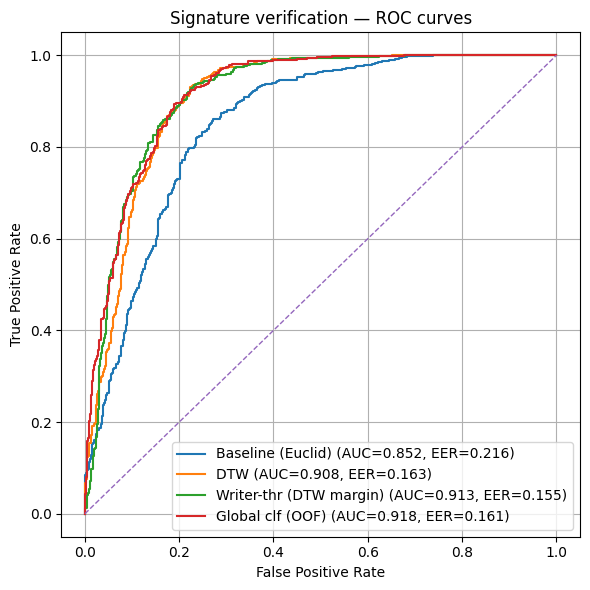

In [ ]:
plt.figure(figsize=(6,6))
for m in methods:
    roc = m["_roc"]
    plt.plot(roc["fpr"], roc["tpr"], label=f'{m["method"]} (AUC={m["auc"]:.3f}, EER={m["eer"]:.3f})')
plt.plot([0,1],[0,1], linestyle="--", linewidth=1)
plt.title("Signature verification — ROC curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

#### Results analysis 

Here we compare our four decision strategies :
* Baseline, with Euclidean template matching
* DTW template matching
* writer-thr, which is : Writer-dependent thresholding using enrollement calibration
* Global clf (OOF), a global classifier trained on engineered features with GroupKFold by writer

All three upgraded methods have outperformed the Baseline on most operating points. This shows that the baseline fails because of the temporal variability and the limited representativity of signle fixed alignments.

DTW has a gap in its performances compared with Writer-thr and Global clf up to 0.1 False positive rate. But then has similar results, even outperforming them around the 0.3 FPR mark. This is an indicator that time-wraping/speed differences are a key source of intra-writer variability in online signatures.

Writer-thr has the loest EER in this run. This is expected, it calibrates a personalited decision rule per writer. Global clf yields thes overall best AUC while evaluated in a more general setting (OOF), since is learns to combine multiple cues (DTW dist. + Euclidean dist. to enrollment + simple dynamic/statistics).

The preferred method depends on the target senario:
* For a biometric style system per enrolled writer, go with writer calibrated threholds.
* For a generalization across writers, GroupKFlod classier is a great choice.


### 8.4 Per-writer AUC breakdown for each method


Worst writers for: Baseline (Euclid)


,writer_id,auc
0,022,0.568
1,029,0.622
2,015,0.722
3,027,0.790
4,023,0.806



Worst writers for: DTW


,writer_id,auc
0,029,0.602
1,022,0.652
2,015,0.748
3,023,0.766
4,027,0.788



Worst writers for: Writer-thr margin


,writer_id,auc
0,029,0.602
1,022,0.652
2,015,0.748
3,023,0.766
4,027,0.788



Worst writers for: Global clf (OOF)


,writer_id,auc
0,029,0.730
1,023,0.768
2,022,0.774
3,015,0.778
4,014,0.786


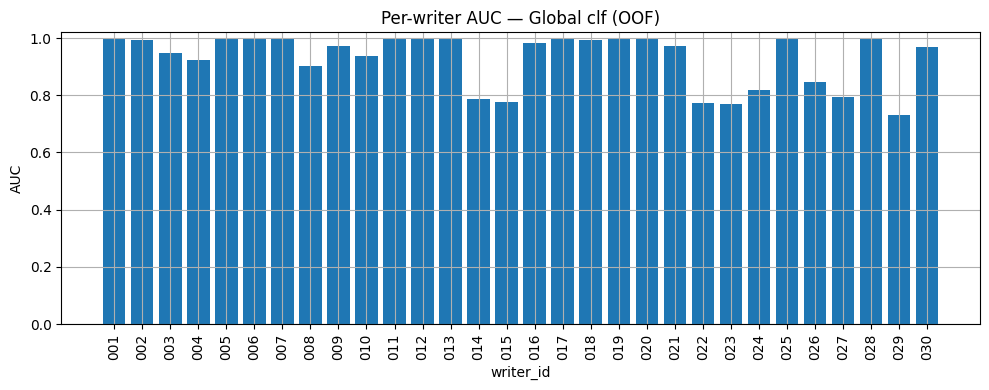

In [ ]:
def per_writer_auc_from_scores(df: pd.DataFrame, score_col: str, higher_is_genuine: bool):
    rows = []
    for w, g in df.groupby("writer_id"):
        yt = g["y"].astype(int).to_numpy()
        if len(np.unique(yt)) < 2:
            continue
        ys = g[score_col].to_numpy().astype(float)
        if not higher_is_genuine:
            ys = -ys
        rows.append({"writer_id": w, "auc": roc_auc_score(yt, ys)})
    return pd.DataFrame(rows).sort_values("auc").reset_index(drop=True)

pw = {
    "Baseline (Euclid)": per_writer_auc_from_scores(eval_df, "baseline_score", higher_is_genuine=False),
    "DTW":               per_writer_auc_from_scores(eval_df, "dtw_score",      higher_is_genuine=False),
    "Writer-thr margin": per_writer_auc_from_scores(eval_df, "thr_margin",     higher_is_genuine=True),
    "Global clf (OOF)":  per_writer_auc_from_scores(eval_df.dropna(subset=["clf_proba"]), "clf_proba", higher_is_genuine=True),
}

for k, dfk in pw.items():
    print("\nWorst writers for:", k)
    display(dfk.head(5))

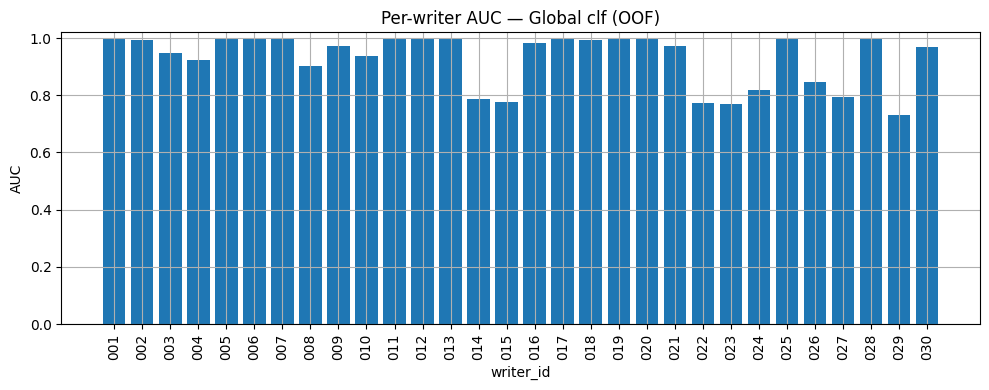

In [63]:
# plot per-writer AUC for best method (change key if you want)
key = "Global clf (OOF)"
dfk = pw[key].sort_values("writer_id")
plt.figure(figsize=(10,4))
plt.bar(dfk["writer_id"], dfk["auc"])
plt.xticks(rotation=90)
plt.ylim(0,1.02)
plt.title(f"Per-writer AUC — {key}")
plt.xlabel("writer_id")
plt.ylabel("AUC")
plt.tight_layout()
plt.show()

Here we performance down by writer instead of looking only at global averages. The small tables list the 5 writers with the lowest AUC for each method, and the bar plot shows the AUC for every writer for the global classifier.

For the Euclidean baseline, the hardest writers are 022 (AUC 0.568) and 029 (0.622), followed by 015, 027, and 023. This means that for those writers, genuine and forgery scores overlap a lot, so ranking genuine above forgery is difficult.

With DTW, the set of hard writers is almost the same. Writer 029 is still the worst (0.602) and writer 022 is still very low (0.652). Writers 015, 023, and 027 also remain in the bottom group. This shows that DTW improves global performance but does not completely fix the writers that are intrinsically difficult.

Writer-threshold margin produces the same bottom-5 list as DTW (029, 022, 015, 023, 027) with the same AUC values here. This is expected because this metric is a monotonic transform of the DTW score within each writer, so the ranking behavior behind AUC stays very similar.

For the global classifier, the worst writers change slightly and the minimum AUC is higher: writer 029 is still the hardest (0.730), then 023 (0.768), 022 (0.774), 015 (0.778), and 014 (0.786). So the classifier reduces how catastrophic the hardest cases are, but it does not remove the writer-dependence completely.

On the bar plot (global classifier per-writer AUC), most writers are close to 1.0, meaning they are easy to separate, while a small group sits around 0.75–0.8 (notably writers like 029, 023, 022, 015, 014). Overall, the figure shows that difficulty is concentrated in a few writers, likely due to higher intra-writer variability, stronger forgery similarity, or both.


### 8.5 Error analysis: show a few confident mistakes for a chosen method

False accepts (forgery predicted genuine):


,writer_id,sig_id,y,baseline_score,dtw_score,thr_margin,clf_proba,margin
966,022,22,0,910.251970,7285.386320,6318.384779,0.993985,0.372574
950,022,06,0,1001.789637,5904.572225,7699.198874,0.993944,0.372533
972,022,28,0,1158.702570,9145.234537,4458.536562,0.988203,0.366792


False rejects (genuine predicted forgery):


,writer_id,sig_id,y,baseline_score,dtw_score,thr_margin,clf_proba,margin
668,015,39,1,5333.274188,37871.222158,-28211.760952,0.001531,0.619879
621,014,37,1,3991.995999,17331.148215,-7621.885787,0.025509,0.595902
667,015,38,1,3399.364958,23203.091544,-13543.630338,0.041284,0.580126


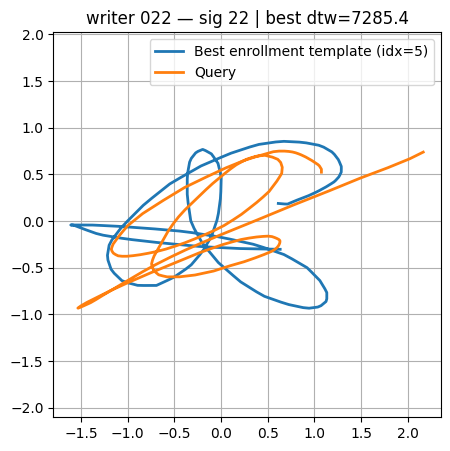

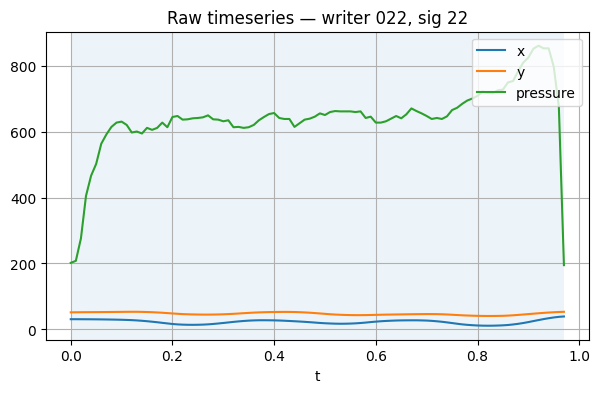

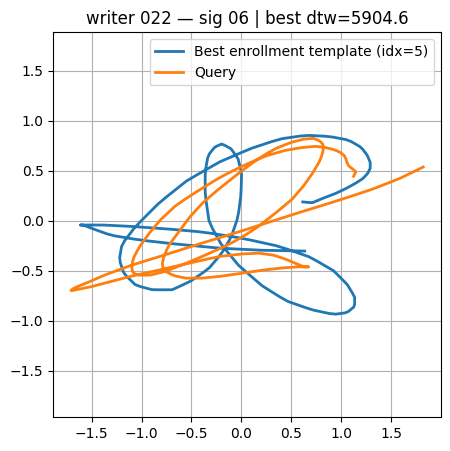

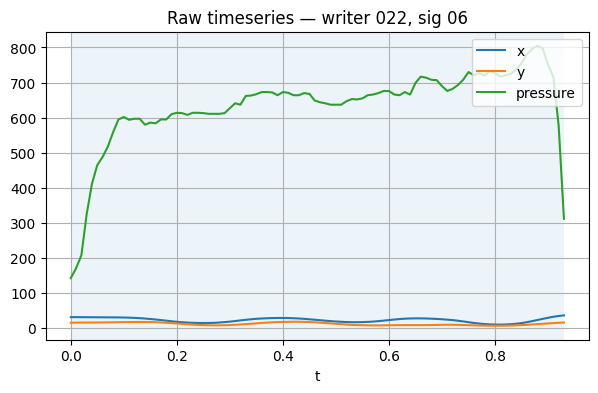

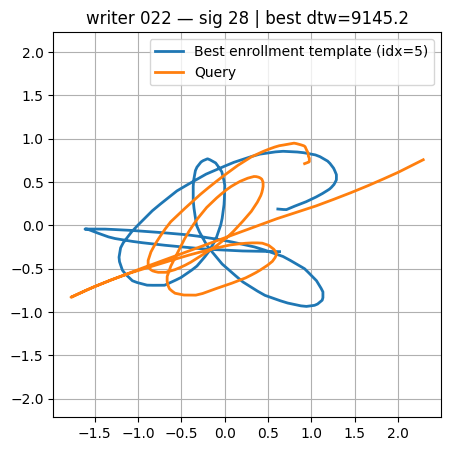

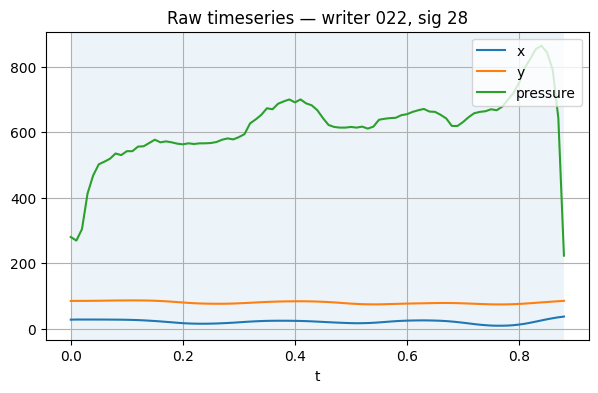

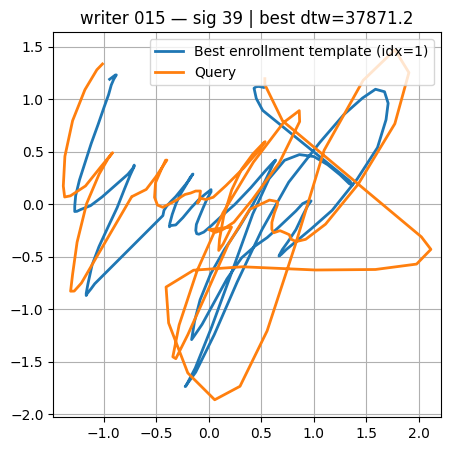

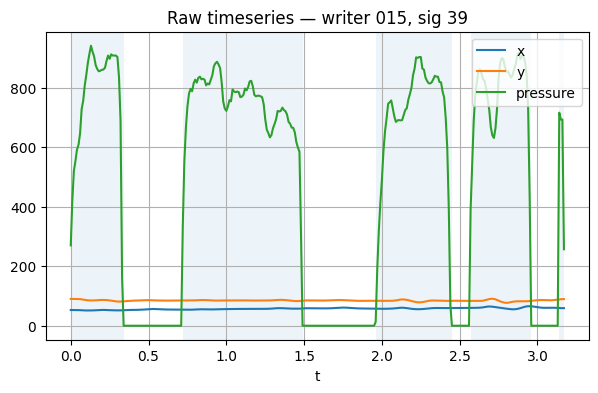

In [ ]:
def pick_errors(method_dict, top_k=3):
    y_true = method_dict["_y_true"]
    score = method_dict["_score"]
    thr = method_dict["eer_thr"]
    y_pred = (score >= thr).astype(int)

    margin = np.abs(score - thr)  # confidence
    df_err = eval_df.copy()
    df_err["y_pred"] = y_pred
    df_err["margin"] = margin

    fa = df_err[(df_err["y"]==0) & (df_err["y_pred"]==1)].sort_values("margin", ascending=False).head(top_k)
    fr = df_err[(df_err["y"]==1) & (df_err["y_pred"]==0)].sort_values("margin", ascending=False).head(top_k)
    return fa, fr


def plot_query_vs_best_template(writer_id: str, sig_id: str, metric="dtw", band=20):
    row = eval_df[(eval_df["writer_id"]==writer_id) & (eval_df["sig_id"]==sig_id)].iloc[0]
    q_df = load_sig_from_row(row)

    # preprocess query
    q = preprocess(q_df, pen_down=True, norm_mode="center_scale", N=N_RESAMPLE)[["x","y","pressure"]].to_numpy()
    templates = get_enrollment_templates(writer_id)

    if metric == "dtw":
        dists = [dtw_distance(q, t, band=band) for t in templates]
    else:
        dists = [float(np.linalg.norm(q - t)) for t in templates]

    j = int(np.argmin(dists))
    t = templates[j]

    plt.figure(figsize=(5,5))
    plt.plot(t[:,0], t[:,1], linewidth=2, label=f"Best enrollment template (idx={j+1})")
    plt.plot(q[:,0], q[:,1], linewidth=2, label="Query")
    plt.axis("equal")
    plt.title(f"writer {writer_id} — sig {sig_id} | best {metric}={dists[j]:.1f}")
    plt.legend()
    plt.show()

    # raw timeseries
    plot_timeseries(q_df, title=f"Raw timeseries — writer {writer_id}, sig {sig_id}")


# Choose which method to inspect errors for:
chosen = [m for m in methods if m["method"] == "Global clf (OOF)"][0]

fa, fr = pick_errors(chosen, top_k=3)
print("False accepts (forgery predicted genuine):")
display(fa[["writer_id","sig_id","y","baseline_score","dtw_score","thr_margin","clf_proba","margin"]])

print("False rejects (genuine predicted forgery):")
display(fr[["writer_id","sig_id","y","baseline_score","dtw_score","thr_margin","clf_proba","margin"]])

# Plot a couple:
for _, r in pd.concat([fa, fr]).head(4).iterrows():
    plot_query_vs_best_template(r["writer_id"], r["sig_id"], metric="dtw", band=BAND)


#### Error analysis (most confident mistakes)

We inspected the most confident errors for the chosen method (Global classifier / OOF), i.e., samples with the largest margin to the decision threshold.

##### False accepts (forgeries predicted genuine)
All three most confident false accepts come from **writer 022** (sig 22, 06, 28) with extremely high predicted probabilities (**~0.99**).  
Visually, the forged queries (orange) follow the enrollment template (blue) after normalization, and their distances are also “genuine-like”:
- **baseline_score is low** (≈ 900–1150)
- **DTW is relatively low** (≈ 5900–9150)
- **thr_margin is strongly positive**, meaning they are also below the writer threshold (they would likely be accepted by thresholding too)

This suggests a *skilled/shape-matching* forgery mode: when the global trajectory is well imitated, distance-based cues (Euclid/DTW) and the learned classifier both become overconfident.

##### False rejects (genuine predicted forgery)
The strongest false reject is **writer 015, sig 39** (clf_proba ≈ 0.0015), with an extremely large mismatch to enrollment:
- **DTW is very high** (≈ 37871)
- **thr_margin is strongly negative**, so the writer-threshold rule also rejects it

The plot supports this: the query trajectory differs substantially from the best enrollment template, and the raw pressure trace shows **multiple long pen-up segments** (pressure at 0) and a very “fragmented” signing process. This indicates a second failure mode: *high intra-writer variability / atypical execution* (possibly many strokes, pauses, or different dynamics), which leads the template match to break down and pushes the classifier toward “forgery”.

Overall, errors concentrate on a small subset of writers (e.g., writer 022 for false accepts, writer 015 for false rejects), showing that writer-specific variability and skilled imitation remain the hardest cases.


## 9. Export results

In [ ]:
OUT = Path("outputs")
OUT.mkdir(exist_ok=True)

# Save evaluation table (all methods in one place)
eval_df.to_csv(OUT / "eval_scores.csv", index=False)

# Save global metrics summary
summary.to_csv(OUT / "global_metrics.csv", index=False)

# Save per-writer AUC tables
for k, dfk in pw.items():
    safe = k.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("-", "minus")
    dfk.to_csv(OUT / f"per_writer_auc__{safe}.csv", index=False)

print("Saved:")
print(" -", OUT / "eval_scores.csv")
print(" -", OUT / "global_metrics.csv")
print(" - per-writer AUC CSVs")


Saved:
 - outputs\eval_scores.csv
 - outputs\global_metrics.csv
 - per-writer AUC CSVs
